# Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

# Kill warnings

In [ ]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Imports

In [ ]:
# Librerie per la manipolazione e visualizzazione dei dati
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Librerie per il machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

# TensorFlow e Keras per il deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Embedding, Bidirectional,
    GRU, Dropout, BatchNormalization, Dense, GlobalMaxPooling1D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import tensorflow.keras as keras
from keras.layers import concatenate

In [ ]:
plt.style.use('seaborn')
sns.set_palette("deep")

<ipython-input-2-094a45b03428>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Load Dataset

In [ ]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [ ]:
len(df)

159571

# Analisi descrittiva dati

## Distribuzione per tossicità
Esaminiamo la distribuzione delle diverse categorie di tossicità presenti nel nostro dataset. Il grafico a barre fornisce una rappresentazione visiva immediata della frequenza relativa di ciascuna categoria di contenuto problematico.

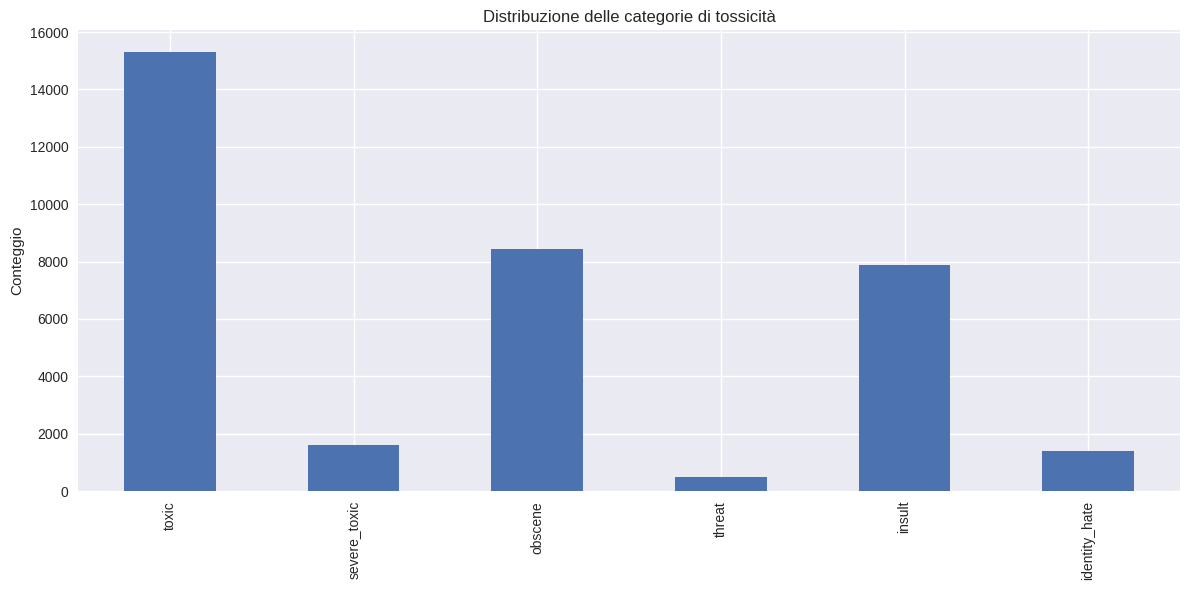

In [ ]:
# Crea una figura di dimensioni 12x6 pollici
plt.figure(figsize=(12, 6))

# Somma i valori per ogni categoria di tossicità e crea un grafico a barre
df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot(kind='bar')

# Aggiunge un titolo al grafico
plt.title('Distribuzione delle categorie di tossicità')

# Etichetta l'asse y
plt.ylabel('Conteggio')

# Aggiusta automaticamente il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il grafico
plt.show()

## Analisi della Correlazione tra Categorie di Tossicità
In questa sezione, esploreremo le relazioni tra le diverse categorie di tossicità nel nostro dataset attraverso una mappa di calore (heatmap) delle correlazioni.

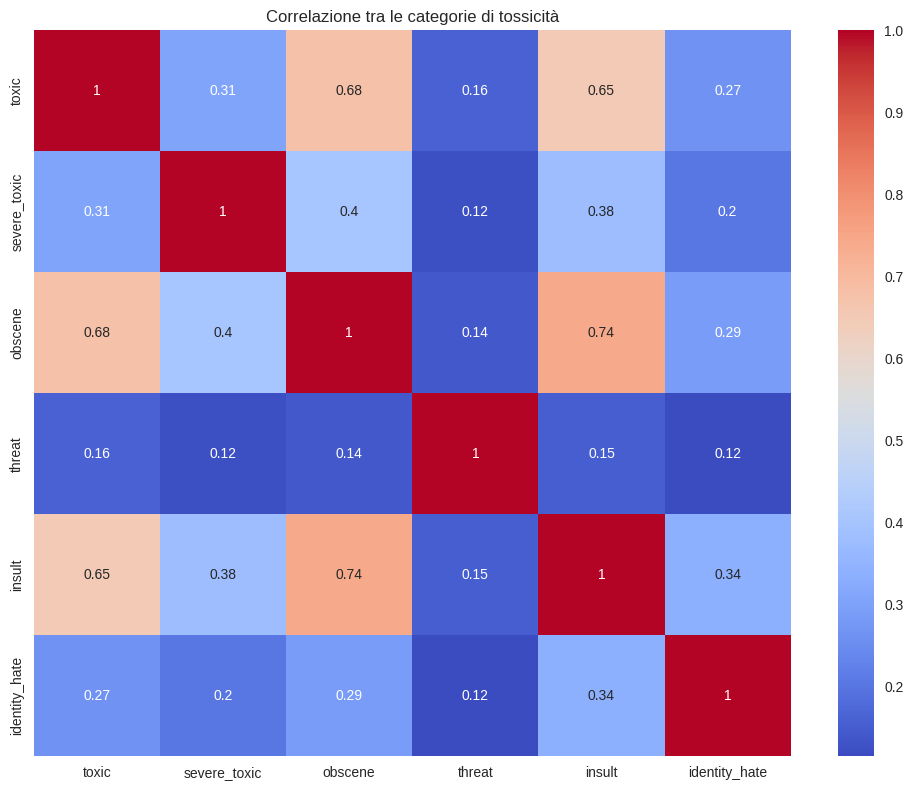

In [ ]:
# Crea una figura di dimensioni 10x8 pollici
plt.figure(figsize=(10, 8))

# Genera una mappa di calore delle correlazioni tra le categorie di tossicità
sns.heatmap(
    # Calcola la matrice di correlazione per le colonne specificate
    df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr(),
    # Aggiunge le annotazioni dei valori in ogni cella
    annot=True,
    # Utilizza la palette di colori 'coolwarm' (rosso per positivo, blu per negativo)
    cmap='coolwarm'
)

# Aggiunge un titolo al grafico
plt.title('Correlazione tra le categorie di tossicità')

# Ottimizza il layout per evitare sovrapposizioni
plt.tight_layout()

# Visualizza il grafico
plt.show()

## Alcune statistiche
In questa sezione vengono stampate alcune informazioni utili a descrivere il dataset

In [ ]:
# Percentuale di commenti tossici
toxic_percentage = (df['toxic'].sum() / len(df)) * 100
print(f"Percentuale di commenti tossici: {toxic_percentage:.2f}%")

Percentuale di commenti tossici: 9.58%


In [ ]:
# Media di sum_injurious
mean_sum_injurious = df['sum_injurious'].mean()
print(f"Media di sum_injurious: {mean_sum_injurious:.2f}")

Media di sum_injurious: 0.22


## Analisi delle Combinazioni di Tossicità
In questa sezione, esploreremo le combinazioni di categorie di tossicità presenti nel nostro dataset e analizzeremo la prevalenza di ciascuna categoria singola.

### Metodi

In [ ]:
def get_toxicity_categories(row, toxic_categories):
    """
    Ottiene le categorie di tossicità presenti per una riga del dataframe.
    """
    return '+'.join([cat for cat in toxic_categories if row[cat]])

def analyze_toxicity_combinations(df, toxic_categories):
    """
    Analizza e visualizza le combinazioni di categorie di tossicità.
    """
    df['toxicity_categories'] = df.apply(lambda row: get_toxicity_categories(row, toxic_categories), axis=1)
    all_toxicity_counts = df['toxicity_categories'].value_counts()
    all_toxicity_percentages = (all_toxicity_counts / len(df)) * 100

    print_toxicity_summary(all_toxicity_counts, all_toxicity_percentages)
    plot_top_toxicity_combinations(all_toxicity_percentages)

def print_toxicity_summary(counts, percentages):
    """
    Stampa un riepilogo di tutte le combinazioni di tossicità.
    """
    print("Riepilogo di tutte le combinazioni di tossicità:")
    print(f"{'Combinazione':<60} {'Conteggio':<10} {'Percentuale':<10}")
    print("-" * 80)
    for combination, count in counts.items():
        percentage = percentages[combination]
        combination = "Non tossico" if combination == "" else combination
        print(f"{combination:<60} {count:<10} {percentage:.2f}%")

def plot_top_toxicity_combinations(percentages):
    """
    Crea un grafico delle top 10 combinazioni di tossicità.
    """
    plt.figure(figsize=(12, 6))
    top_10_combinations = percentages[percentages.index != ""].nlargest(10)
    sns.barplot(x=top_10_combinations.index, y=top_10_combinations.values)
    plt.title('Top 10 Combinazioni di Tossicità (esclusi non tossici)', fontsize=16)
    plt.xlabel('Combinazioni', fontsize=12)
    plt.ylabel('Percentuale dei commenti totali', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(top_10_combinations.values):
        plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

def analyze_single_categories(df, toxic_categories):
    """
    Analizza e visualizza la prevalenza delle singole categorie di tossicità.
    """
    category_summary = []
    for category in toxic_categories:
        count = df[category].sum()
        percentage = (count / len(df)) * 100
        category_summary.append((category, count, percentage))
    category_summary.sort(key=lambda x: x[1], reverse=True)

    print_category_summary(category_summary, df, toxic_categories)
    plot_single_categories(category_summary)

def print_category_summary(summary, df, toxic_categories):
    """
    Stampa un riepilogo delle singole categorie di tossicità.
    """
    print("\nRiepilogo delle singole categorie di tossicità:")
    print(f"{'Categoria':<15} {'Conteggio':<10} {'Percentuale':<10}")
    print("-" * 35)
    for category, count, percentage in summary:
        print(f"{category:<15} {count:<10} {percentage:.2f}%")

    non_toxic_count = len(df[df[toxic_categories].sum(axis=1) == 0])
    non_toxic_percentage = (non_toxic_count / len(df)) * 100
    print(f"{'Non tossico':<15} {non_toxic_count:<10} {non_toxic_percentage:.2f}%")

def plot_single_categories(summary):
    """
    Crea un grafico per le singole categorie di tossicità.
    """
    plt.figure(figsize=(10, 6))
    categories = [cat for cat, _, _ in summary]
    percentages = [perc for _, _, perc in summary]
    sns.barplot(x=categories, y=percentages)
    plt.title('Prevalenza delle Categorie di Tossicità (esclusi non tossici)', fontsize=16)
    plt.xlabel('Categorie', fontsize=12)
    plt.ylabel('Percentuale dei commenti totali', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(percentages):
        plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

### Stampe

In [ ]:
analyze_toxicity_combinations(df, toxic_categories)
analyze_single_categories(df, toxic_categories)
print(f"\nTotale commenti analizzati: {len(df)}")

## Analisi della Distribuzione delle Categorie Tossiche
Questa sezione esamina la distribuzione del numero di categorie tossiche per commento nel dataset. L'obiettivo è comprendere quanto spesso i commenti tossici rientrano in multiple categorie, fornendo insight sulla complessità della tossicità online. L'analisi include una visualizzazione grafica e un riepilogo statistico, escludendo i commenti non tossici per focalizzarsi sui pattern di tossicità multipla.

### Metodi

In [ ]:
def calculate_toxic_categories(df, toxic_categories):
    """Calcola il numero di categorie tossiche per ogni commento."""
    return df[toxic_categories].sum(axis=1)

def plot_toxic_categories_distribution(df):
    """Crea un grafico a barre della distribuzione delle categorie tossiche."""
    plt.figure(figsize=(10, 6))
    sns.countplot(x='num_toxic_categories', data=df[df['num_toxic_categories'] > 0], palette="viridis")
    plt.title('Distribuzione del numero di categorie tossiche per commento', fontsize=16, fontweight='bold')
    plt.xlabel('Numero di categorie tossiche', fontsize=12)
    plt.ylabel('Conteggio dei commenti', fontsize=12)

    # Aggiunge etichette di conteggio e percentuale sopra ogni barra
    total = len(df[df['num_toxic_categories'] > 0])
    for p in plt.gca().patches:
        count = p.get_height()
        percentage = 100 * count / total
        plt.annotate(f'{count}\n({percentage:.1f}%)', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def print_distribution_summary(df):
    """Stampa un riepilogo della distribuzione delle categorie tossiche."""
    total = len(df[df['num_toxic_categories'] > 0])
    distribution = df[df['num_toxic_categories'] > 0]['num_toxic_categories'].value_counts().sort_index()
    percentage_distribution = (distribution / total) * 100

    print("\nDistribuzione del numero di categorie tossiche per commento (esclusi i non tossici):")
    print(f"{'Numero di categorie':<20} {'Conteggio':<10} {'Percentuale':>10}")
    print("-" * 45)

    for num, count in distribution.items():
        percentage = percentage_distribution[num]
        print(f"{num:<20} {count:<10} {percentage:>10.2f}%")

    print("-" * 45)

def analyze_toxic_categories_distribution(df, toxic_categories):
    """Analizza e visualizza la distribuzione delle categorie tossiche."""
    df['num_toxic_categories'] = calculate_toxic_categories(df, toxic_categories)
    plot_toxic_categories_distribution(df)
    print_distribution_summary(df)

### Stampe

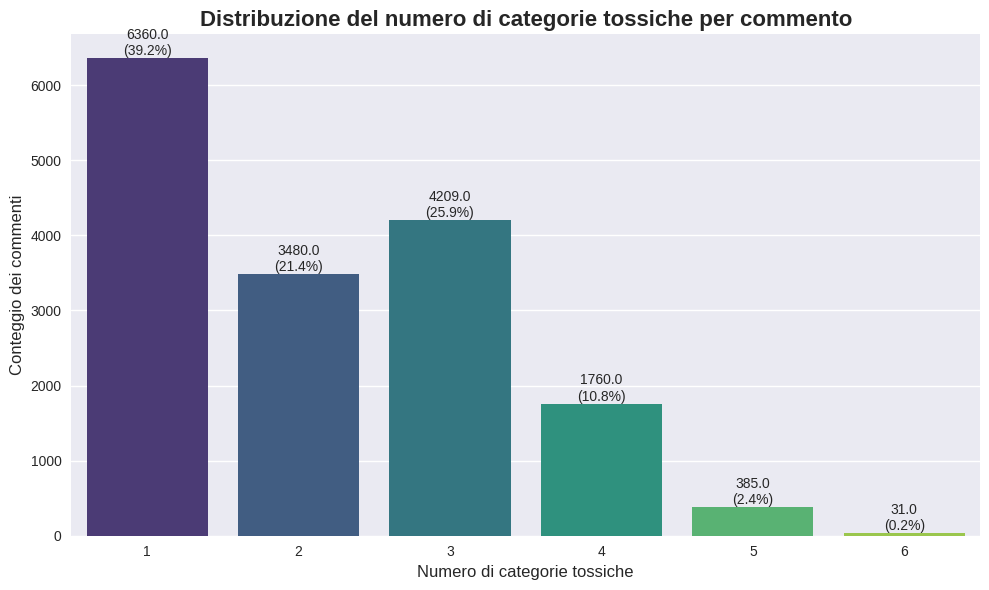


Distribuzione del numero di categorie tossiche per commento (esclusi i non tossici):
Numero di categorie  Conteggio  Percentuale
---------------------------------------------
1                    6360            39.20%
2                    3480            21.45%
3                    4209            25.94%
4                    1760            10.85%
5                    385              2.37%
6                    31               0.19%
---------------------------------------------


In [ ]:
toxic_categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
analyze_toxic_categories_distribution(df.copy(), toxic_categories)

# Bilanciamento delle Classi
Lo sbilanciamento delle classi è un problema comune nell'analisi dei contenuti online, dove alcune categorie (es. commenti non tossici) possono essere molto più frequenti di altre. Questo può portare a:

- Bias del modello verso le classi maggioritarie
- Prestazioni scarse sulle classi minoritarie
- Metriche di valutazione potenzialmente fuorvianti

## Processo di Bilanciamento delle Classi
Questo codice implementa un approccio adattivo al bilanciamento delle classi per un dataset di commenti classificati in base a diverse categorie di tossicità.

Il processo inizia con la preparazione dei dati, combinando il testo dei commenti con etichette binarie aggregate. Successivamente, analizza la distribuzione delle classi, identificando quelle rare basate su una soglia predefinita.

Il cuore dell'algoritmo è una tecnica di resampling adattivo: applica un undersampling alla classe maggioritaria (commenti non tossici) e un oversampling alle classi minoritarie o rare. Questo approccio mira a creare un dataset più equilibrato, migliorando la rappresentazione delle classi meno frequenti senza eliminare completamente la naturale asimmetria dei dati.

Infine, il codice fornisce statistiche comparative dettagliate sulla distribuzione delle classi prima e dopo il bilanciamento, permettendo una valutazione immediata dell'efficacia del processo.

**N.B. si sono provate anche le tecniche "standard" di SMOTE e Undersampling ma essendo la classificazione multilabel e avendo difficoltà a produrre nuovi dati sensati si è optato per questo approccio**

In [ ]:
def prepare_data(df: pd.DataFrame, label_columns: list) -> pd.DataFrame:
    """
    Prepara i dati combinando il testo dei commenti con le etichette aggregate.

    Args:
        df (pd.DataFrame): DataFrame contenente i dati originali.
        label_columns (list): Lista delle colonne contenenti le etichette binarie.

    Returns:
        pd.DataFrame: DataFrame combinato con testo dei commenti e etichette aggregate.
    """
    X = df['comment_text']
    y = df[label_columns]
    y['label'] = y.apply(lambda row: ''.join(row.astype(int).astype(str)), axis=1)
    return pd.concat([X, y['label']], axis=1)

def analyze_class_distribution(combined_df: pd.DataFrame, rare_threshold: float = 0.5) -> tuple:
    """
    Analizza la distribuzione delle classi e identifica le classi rare.

    Args:
        combined_df (pd.DataFrame): DataFrame combinato con testo e etichette.
        rare_threshold (float): Soglia percentuale per considerare una classe come rara.

    Returns:
        tuple: Conteggio delle classi, percentuali delle classi, lista delle classi rare.
    """
    class_counts = combined_df['label'].value_counts()
    total_samples = len(combined_df)
    class_percentages = (class_counts / total_samples * 100).sort_values()
    rare_classes = class_percentages[class_percentages < rare_threshold].index.tolist()
    return class_counts, class_percentages, rare_classes

def adaptive_resampling(combined_df: pd.DataFrame, class_counts: pd.Series, rare_classes: list, non_toxic_class: str = '000000') -> pd.DataFrame:
    """
    Esegue un resampling adattivo del dataset per bilanciare le classi.

    Args:
        combined_df (pd.DataFrame): DataFrame combinato con testo e etichette.
        class_counts (pd.Series): Conteggio delle classi.
        rare_classes (list): Lista delle classi rare.
        non_toxic_class (str): Etichetta per la classe non tossica.

    Returns:
        pd.DataFrame: DataFrame bilanciato dopo il resampling.
    """
    total_samples = len(combined_df)
    threshold_under = int(0.6 * total_samples)
    threshold_over = int(0.01 * total_samples)

    resampled_dfs = []
    for label in class_counts.index:
        df_class = combined_df[combined_df['label'] == label]
        if label == non_toxic_class and len(df_class) > threshold_under:
            df_class = resample(df_class, replace=False, n_samples=threshold_under, random_state=42)
        elif label in rare_classes or len(df_class) < threshold_over:
            df_class = resample(df_class, replace=True, n_samples=max(threshold_over, len(df_class)), random_state=42)
        resampled_dfs.append(df_class)

    return pd.concat(resampled_dfs)

def split_features_labels(balanced_df: pd.DataFrame, label_columns: list) -> tuple:
    """
    Separa le features e le etichette dal DataFrame bilanciato.

    Args:
        balanced_df (pd.DataFrame): DataFrame bilanciato dopo il resampling.
        label_columns (list): Lista delle colonne contenenti le etichette binarie.

    Returns:
        tuple: Features (X) e etichette (y) separate.
    """
    X_balanced = balanced_df['comment_text']
    y_balanced = balanced_df['label'].apply(lambda x: pd.Series(list(x))).astype(int)
    y_balanced.columns = label_columns
    return X_balanced, y_balanced

def print_statistics(X_balanced: pd.Series, y_balanced: pd.DataFrame, original_percentages: pd.Series, new_percentages: pd.Series):
    """
    Stampa le statistiche comparative prima e dopo il bilanciamento.

    Args:
        X_balanced (pd.Series): Features bilanciate.
        y_balanced (pd.DataFrame): Etichette bilanciate.
        original_percentages (pd.Series): Percentuali originali delle classi.
        new_percentages (pd.Series): Percentuali delle classi dopo il bilanciamento.
    """
    print(f"\nShape of balanced features: {X_balanced.shape}")
    print(f"Shape of balanced labels: {y_balanced.shape}")
    print("\nDistribution of classes after balancing:")
    for col in y_balanced.columns:
        print(f"{col}: {y_balanced[col].sum()}")

    print("\nComparison of class distributions:")
    comparison = pd.DataFrame({
        'Original %': original_percentages,
        'Resampled %': new_percentages
    })
    print(comparison)

def balance_toxic_comment_classes(df: pd.DataFrame, label_columns: list, rare_threshold: float = 0.5):
    """
    Esegue l'intero processo di bilanciamento delle classi per il dataset di commenti tossici.

    Questa funzione coordina l'intero flusso di lavoro per il bilanciamento delle classi,
    inclusa la preparazione dei dati, l'analisi della distribuzione delle classi,
    il resampling adattivo e la presentazione delle statistiche finali.

    Args:
        df (pd.DataFrame): DataFrame originale contenente i dati dei commenti e le etichette.
        label_columns (list): Lista delle colonne contenenti le etichette binarie per le categorie di tossicità.
        rare_threshold (float, optional): Soglia percentuale per considerare una classe come rara. Default è 0.5%.

    Note:
        Il processo include l'identificazione di classi rare, l'undersampling della classe maggioritaria (non tossica)
        e l'oversampling delle classi minoritarie o rare.
    """
    combined_df = prepare_data(df, label_columns)
    class_counts, class_percentages, rare_classes = analyze_class_distribution(combined_df, rare_threshold)

    print("Distribuzione originale delle classi:")
    print(class_percentages)
    print(f"\nClassi rare (sotto {rare_threshold}%):")
    print(rare_classes)

    balanced_df = adaptive_resampling(combined_df, class_counts, rare_classes)
    X_balanced, y_balanced = split_features_labels(balanced_df, label_columns)

    new_class_counts = balanced_df['label'].value_counts()
    new_class_percentages = (new_class_counts / len(balanced_df) * 100).sort_values()

    print_statistics(X_balanced, y_balanced, class_percentages, new_class_percentages)
    return X_balanced, y_balanced

label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X_balanced, y_balanced = balance_toxic_comment_classes(df, label_columns, rare_threshold=0.5)

Distribuzione originale delle classi:
label
110101     0.000627
110110     0.000627
001100     0.001253
001110     0.001253
001001     0.001880
100111     0.001880
000110     0.001880
110001     0.001880
111100     0.002507
111001     0.003760
110011     0.004387
100101     0.004387
101100     0.006893
110100     0.006893
110010     0.008774
100110     0.010027
001011     0.011280
000100     0.013787
000011     0.017547
111111     0.019427
101001     0.021934
110000     0.025694
000001     0.033841
101111     0.035094
111110     0.040108
100100     0.070815
101110     0.082095
100011     0.083975
100001     0.085229
111000     0.099015
001010     0.113429
111011     0.166070
000010     0.188631
001000     0.198658
101011     0.387288
111010     0.619787
100010     0.761417
101000     1.101704
101010     2.381385
100000     3.550771
000000    89.832112
Name: count, dtype: float64

Classi rare (sotto 0.5%):
['110101', '110110', '001100', '001110', '001001', '100111', '000110', '110001', 

In [ ]:
y_balanced.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
46733,0,0,0,0,0,0
110326,0,0,0,0,0,0
76687,0,0,0,0,0,0
36231,0,0,0,0,0,0
21514,0,0,0,0,0,0


# Tokenizzazione

Il codice analizza la lunghezza dei commenti in un dataset bilanciato, calcolando statistiche come la lunghezza massima, media, mediana e il 95° percentile.

In [ ]:
# Assumiamo che X_balanced contenga i testi dei commenti bilanciati
X = X_balanced
y = y_balanced

# Calcola la lunghezza di ogni commento (numero di parole)
comment_lengths = X.apply(lambda x: len(x.split()))

# Calcola statistiche sulla lunghezza
max_comment_length = comment_lengths.max()
avg_comment_length = int(comment_lengths.mean())
median_comment_length = int(comment_lengths.median())
percentile_95 = int(np.percentile(comment_lengths, 95))

# Stampa le statistiche calcolate
print(f"Lunghezza massima dei commenti: {max_comment_length}")
print(f"Lunghezza media dei commenti: {avg_comment_length}")
print(f"Lunghezza mediana dei commenti: {median_comment_length}")
print(f"95° percentile della lunghezza dei commenti: {percentile_95}")

Lunghezza massima dei commenti: 1411
Lunghezza media dei commenti: 73
Lunghezza mediana dei commenti: 32
95° percentile della lunghezza dei commenti: 252


Il codice imposta la lunghezza massima (`max_len`) dei commenti al valore del 95° percentile calcolato in precedenza.
Questa scelta permette di coprire la maggior parte dei commenti senza essere influenzati da outlier estremi, ottimizzando il preprocessing dei dati.

In [ ]:
max_len = percentile_95
print(f"max_len impostato a: {max_len}")

max_len impostato a: 252


Il codice definisce e applica una funzione di preprocessing del testo che include la conversione in minuscolo, la rimozione di punteggiatura e caratteri speciali, la tokenizzazione e l'eliminazione delle stopwords.

Questo processo standardizza e pulisce i commenti, riducendo il rumore nei dati e preparandoli per l'addestramento.

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Converti in minuscolo
    text = text.lower()

    # Rimuovi punteggiatura e caratteri speciali
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenizza
    tokens = word_tokenize(text)

    # Rimuovi stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return ' '.join(tokens)

# Applica il preprocessing
X = X.apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Il codice analizza il vocabolario del dataset dopo il preprocessing, calcolando:
1. Il numero totale di parole uniche.
2. La frequenza di ogni parola nel corpus.
3. La dimensione del vocabolario necessaria per coprire il 95% delle occorrenze di parole.

Queste metriche sono cruciali per comprendere la complessità e la diversità linguistica del dataset,
aiutando a definire la dimensione ottimale del vocabolario per i modelli di machine learning.

In [ ]:
# Calcola il numero di parole uniche dopo il preprocessing
unique_words = set()
for comment in X:
    unique_words.update(comment.split())

num_unique_words = len(unique_words)

print(f"Numero totale di parole uniche dopo il preprocessing: {num_unique_words}")

# Calcola la frequenza delle parole
word_freq = {}
for comment in X:
    for word in comment.split():
        word_freq[word] = word_freq.get(word, 0) + 1

# Ordina le parole per frequenza
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Calcola il numero di parole che coprono una certa percentuale del corpus
total_words = sum(word_freq.values())
cumulative_freq = 0
vocab_size = 0
coverage_threshold = 0.95  # Copre il 95% delle occorrenze di parole

for word, freq in sorted_words:
    cumulative_freq += freq
    vocab_size += 1
    if cumulative_freq / total_words > coverage_threshold:
        break

print(f"Numero di parole uniche che coprono il {coverage_threshold*100}% del corpus: {vocab_size}")

Numero totale di parole uniche dopo il preprocessing: 196878
Numero di parole uniche che coprono il 95.0% del corpus: 23029


Imposta max_words basandoci sull'analisi del vocabolario pulito

In [ ]:
max_words = vocab_size + 1
print(f"max_words impostato a: {max_words}")

max_words impostato a: 23030


Il codice esegue la tokenizzazione e la preparazione finale dei dati testuali per l'input del modello:
1. Crea un tokenizer con un vocabolario limitato, includendo un token per le parole fuori vocabolario (OOV).
2. Converte i testi in sequenze numeriche utilizzando il tokenizer.
3. Applica il padding alle sequenze per uniformarne la lunghezza, troncando o aggiungendo zeri se necessario.

Questo processo trasforma il testo in un formato numerico standardizzato, pronto per essere utilizzato
come input per modelli di machine learning, in particolare reti neurali.

In [ ]:
# Tokenizzazione del testo
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

# Converti in sequenze e applica il padding
X = tokenizer.texts_to_sequences(X)

X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

# Definizione modello

## Early stopping custom class
Questa classe implementa una callback personalizzato per l'early stopping in scenari multi-label:
1. Estende la classe EarlyStopping di Keras per monitorare multiple metriche contemporaneamente.
2. Calcola la media di metriche specifiche (AUC-ROC, precisione e recall di default) per valutare le prestazioni.
3. Permette di interrompere l'addestramento quando la performance media su queste metriche smette di migliorare.

In [ ]:
# Custom callback for multi-label early stopping
class MultiLabelEarlyStopping(EarlyStopping):
    def __init__(self, metrics=['val_auc_roc', 'val_precision', 'val_recall'], **kwargs):
        super().__init__(**kwargs)
        self.metrics = metrics

    def get_monitor_value(self, logs=None):
        logs = logs or {}
        monitor_values = [logs.get(m) for m in self.metrics]
        return np.mean(monitor_values)

## Modello
Questa funzione crea un modello ibrido CNN-RNN ottimizzato con layer di attenzione per la classificazione multi-label di testi:

1. **Layer di embedding**: Rappresenta le parole in uno spazio vettoriale denso e regolarizzato.
2. **Layers CNN**: Cattura pattern locali nel testo senza MaxPooling, con normalizzazione batch e dropout per migliorare la generalizzazione.
3. **Layer RNN Bidirezionale (GRU)**: Cattura dipendenze a lungo termine nel testo, con regolarizzazione e dropout.
Layer di attenzione: Esplora le relazioni tra le sequenze di output della RNN per migliorare la focalizzazione sulle informazioni rilevanti.
4. **Combinazione delle features**: Unisce le caratteristiche estratte dai layers CNN, RNN e di attenzione.
5. **Layers densi**: Completano l'architettura con regolarizzazione e dropout, prima di un layer di output per la classificazione multi-label.
6. **Compilazione del modello**: Utilizza l'ottimizzatore Adam e include metriche come AUC-ROC, precisione, recall e accuratezza.


In [ ]:
def create_cnn_rnn_model(vocab_size, max_length, embedding_dim=128):
    """
    Crea un modello ibrido CNN-RNN ottimizzato con layer di attenzione per la classificazione multi-label di testi.

    Args:
        vocab_size (int): Dimensione del vocabolario.
        max_length (int): Lunghezza massima delle sequenze di input.
        embedding_dim (int): Dimensione del vettore di embedding. Default è 128.

    Returns:
        tf.keras.Model: Modello compilato pronto per l'addestramento.
    """
    # Input layer
    inputs = Input(shape=(max_length,))

    # Embedding layer con regolarizzazione
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                          embeddings_regularizer=l2(1e-5))(inputs)

    # Layers CNN senza MaxPooling
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-5))(embedding)
    conv1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.2)(conv1)

    conv2 = Conv1D(filters=128, kernel_size=4, activation='relu', padding='same', kernel_regularizer=l2(1e-5))(drop1)
    conv2 = BatchNormalization()(conv2)
    drop2 = Dropout(0.2)(conv2)

    # Layer RNN
    gru = Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(1e-5), recurrent_regularizer=l2(1e-5)))(drop2)
    gru = BatchNormalization()(gru)
    drop3 = Dropout(0.2)(gru)

    # Layer di attenzione
    attention = tf.keras.layers.Attention()([drop3, drop3])

    # Combinazione features CNN, RNN e Attention
    cnn_features = GlobalMaxPooling1D()(drop2)
    rnn_features = GlobalMaxPooling1D()(drop3)
    attention_features = GlobalMaxPooling1D()(attention)
    combined = concatenate([cnn_features, rnn_features, attention_features])

    # Layers densi
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(1e-5))(combined)
    dense1 = BatchNormalization()(dense1)
    drop4 = Dropout(0.3)(dense1)

    # Layer di output per classificazione multi-label
    outputs = Dense(6, activation='sigmoid')(drop4)

    # Creazione del modello
    model = Model(inputs=inputs, outputs=outputs)

    # Compilazione del modello con metrica AUC-ROC
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            AUC(name='auc_roc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy')
        ]
    )

    return model

Questa funzione esegue l'addestramento e la valutazione del modello:
1. Divide i dati in set di training e test, stratificando per mantenere la distribuzione delle classi.
2. Implementa callbacks per early stopping e riduzione del learning rate.
3. Prepara i dataset utilizzando l'API tf.data.
4. Addestra il modello utilizzando i dataset.
5. Valuta il modello sul set di test e riporta le metriche di performance.

In [ ]:
def train_and_evaluate_model(X, y, model, max_words, max_len, epochs=20):
    """
    Addestra e valuta un modello di classificazione multi-label.

    Args:
        X (np.array): Features di input.
        y (pd.DataFrame): Labels di output.
        model (tf.keras.Model): Modello da addestrare.
        max_words (int): Dimensione del vocabolario.
        max_len (int): Lunghezza massima delle sequenze di input.
        epochs (int): Numero massimo di epoche di addestramento.

    Returns:
        tuple: Modello addestrato, storia dell'addestramento, e set di dati divisi.
    """

    # Aggiungi la colonna 'label' a y
    y['label'] = y.apply(lambda row: ''.join(row.astype(int).astype(str)), axis=1)


    # Divisione dei dati
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y['label']
    )
    y_train = y_train.drop('label', axis=1)
    y_test = y_test.drop('label', axis=1)

    # Callbacks
    early_stopping = MultiLabelEarlyStopping(
        metrics=['val_auc_roc', 'val_precision', 'val_recall'],
        mode='max',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )

    # Preparazione dei dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(32).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    # Addestramento del modello
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Valutazione del modello
    results = model.evaluate(X_test, y_test)
    print(f"Test Loss: {results[0]}")
    print(f"Test AUC-ROC: {results[1]}")
    print(f"Test Precision: {results[2]}")
    print(f"Test Recall: {results[3]}")
    print(f"Test Accuracy: {results[4]}")

    return model, history, X_train, X_test, y_train, y_test

## Addestramento

### Descrizione del Modello

Il modello utilizza un'architettura di deep learning che integra diverse tecniche per l'elaborazione di sequenze di testo:

1. **Input e Embedding**:
   - Le sequenze di lunghezza 252 vengono trasformate in vettori densi di dimensione 128 attraverso un layer di embedding.

2. **Strati Convoluzionali**:
   - Due strati Conv1D con 64 e 128 filtri.

3. **Batch Normalization e Dropout**:
   - Vengono utilizzati per stabilizzare l'addestramento e ridurre il rischio di overfitting.

4. **Strato Ricorrente Bidirezionale (GRU)**:
   - Il layer GRU bidirezionale cattura le dipendenze temporali, migliorando la comprensione del contesto nei commenti.

5. **Meccanismo di Attenzione**:
   - L'attenzione permette al modello di concentrarsi su parti rilevanti della sequenza.

6. **Global Max Pooling e Concatenazione**:
   - Tre strati di pooling estraggono e combinano le caratteristiche più rilevanti.

7. **Strati Densi e Output**:
   - Un layer denso finale con 6 unità classifica i commenti d'odio nelle rispettive categorie.



In [ ]:
tf.keras.backend.clear_session()
model_cnn_rnn = create_cnn_rnn_model(max_words, max_len)
model_cnn_rnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 252)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 252, 128)       │      2,947,840 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 252, 64)        │         24,640 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 252, 64)        │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 126, 64)        │              0 │ batch_normalization[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 126, 64)        │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 126, 128)       │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 126, 128)       │            512 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 63, 128)        │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 63, 128)        │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 63, 128)        │         74,496 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 63, 128)        │            512 │ bidirectional[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 63, 128)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 63, 128)        │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 128)            │              0 │ dropout_1[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_

 Total params: 3,106,438 (11.85 MB)

 Trainable params: 3,105,670 (11.85 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Create model
model, history, X_train, X_test, y_train, y_test = train_and_evaluate_model(X, y, model_cnn_rnn, max_words, max_len)

Epoch 1/20
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 71s 18ms/step - accuracy: 0.8963 - auc_roc: 0.9336 - loss: 0.2606 - precision: 0.7563 - recall: 0.7700 - val_accuracy: 0.9657 - val_auc_roc: 0.9901 - val_loss: 0.1305 - val_precision: 0.9808 - val_recall: 0.8450 - learning_rate: 0.0010
Epoch 2/20
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 65s 18ms/step - accuracy: 0.9714 - auc_roc: 0.9921 - loss: 0.1132 - precision: 0.9413 - recall: 0.9135 - val_accuracy: 0.9707 - val_auc_roc: 0.9936 - val_loss: 0.1174 - val_precision: 0.9839 - val_recall: 0.8678 - learning_rate: 0.0010
Epoch 3/20
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 65s 18ms/step - accuracy: 0.9773 - auc_roc: 0.9943 - loss: 0.1025 - precision: 0.9530 - recall: 0.9322 - val_accuracy: 0.9652 - val_auc_roc: 0.9896 - val_loss: 0.1426 - val_precision: 0.9918 - val_recall: 0.8329 - learning_rate: 0.0010
Epoch 4/20
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9800 - auc_roc: 0.9953 - loss: 0.0967 - precision: 0.9570 - recall: 0.9417
Epoch 4: ReduceLROnPla

## Learning curve

Il codice definisce una funzione plot_learning_curves che visualizza le curve di apprendimento di un modello di machine learning durante l'addestramento.

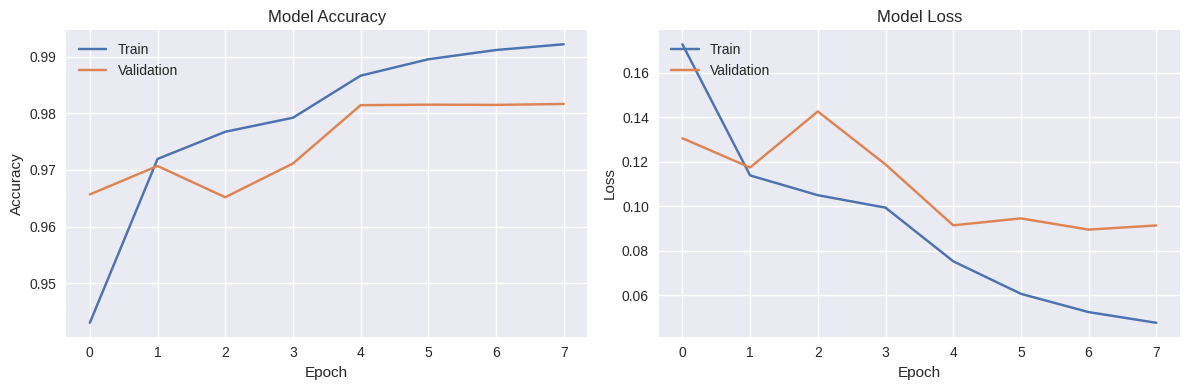

In [ ]:
def plot_learning_curves(history):
    """
    Plot training & validation accuracy and loss values
    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


plot_learning_curves(history)

## Check overfitting

Il codice definisce una funzione `check_overfitting` che verifica se un modello sta overfittando in base alla differenza tra i punteggi di addestramento e di validazione. La funzione calcola la differenza tra l'accuratezza sul set di addestramento e sul set di validazione; se questa differenza supera una soglia specificata (di default 0,1), segnala un potenziale overfitting, altrimenti indica che non è stato rilevato overfitting significativo. Il codice finale esegue questa verifica calcolando l'accuratezza del modello su entrambi i set e passando i risultati alla funzione `check_overfitting`.

In [ ]:
def check_overfitting(train_scores, val_scores, threshold=0.1):
    """
    Check if the model is overfitting based on the difference between training and validation scores.
    """
    diff = train_scores - val_scores
    if diff > threshold:
        print(f"Potential overfitting detected. Difference: {diff:.4f}")
    else:
        print(f"No significant overfitting detected. Difference: {diff:.4f}")

train_acc = model.evaluate(X_train, y_train)[1]
val_acc = model.evaluate(X_test, y_test)[1]
check_overfitting(train_acc, val_acc)

3631/3631 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9953 - auc_roc: 0.9995 - loss: 0.0399 - precision: 0.9979 - recall: 0.9786
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9848 - auc_roc: 0.9904 - loss: 0.0869 - precision: 0.9799 - recall: 0.9434
No significant overfitting detected. Difference: 0.0087


## Training history

Il codice definisce una funzione plot_training_history che visualizza l'andamento di diverse metriche durante l'addestramento di un modello di machine learning. Le metriche tracciate includono la perdita (loss), l'AUC-ROC, la precisione e il recall, sia sui dati di addestramento che su quelli di validazione. I risultati vengono presentati in una griglia di quattro grafici (2x2), ciascuno dedicato a una delle metriche. Dopo aver tracciato le curve di apprendimento per ogni metrica, la funzione mostra i grafici per facilitare l'analisi delle prestazioni del modello nel tempo.

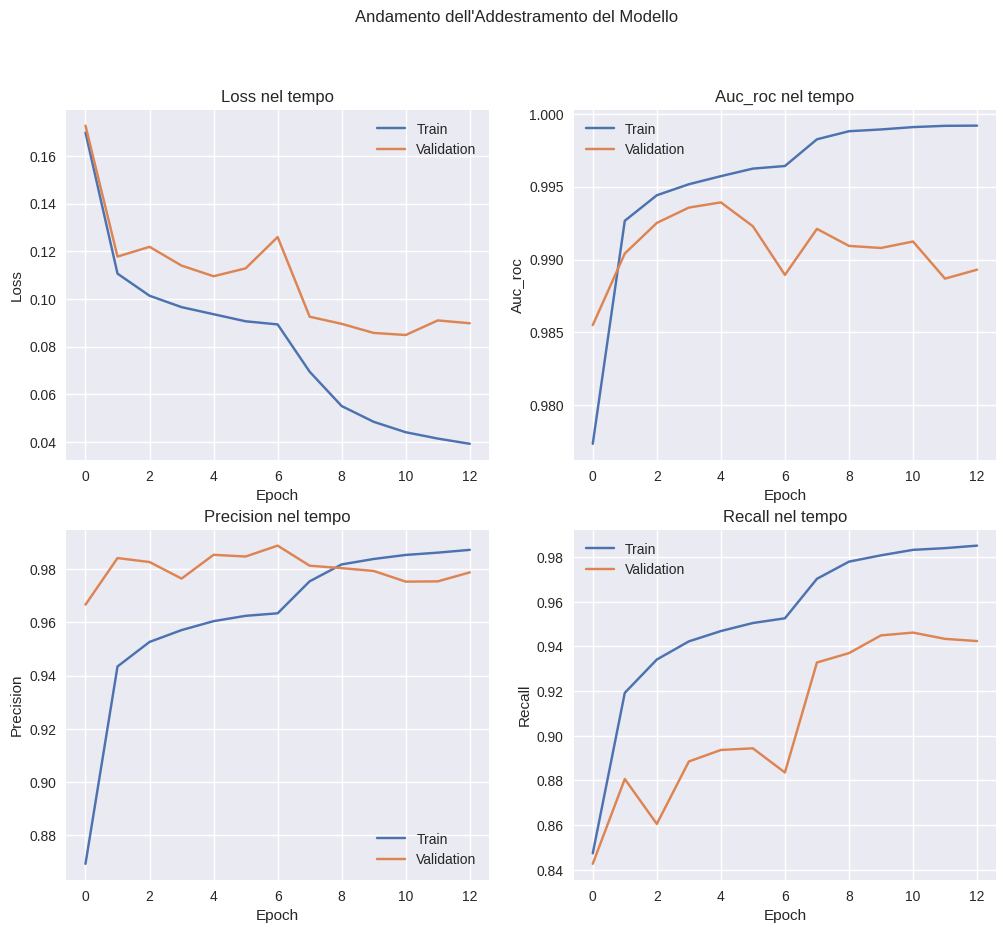

In [ ]:
def plot_training_history(history):
    """
    Traccia l'andamento dell'addestramento e della validazione di un modello per specifiche metriche.

    Parametri:
    history : oggetto History
        L'oggetto history restituito dal metodo `fit` di un modello Keras,
        contenente le metriche registrate durante l'addestramento.

    Metriche Tracciate:
    - Loss (Perdita)
    - AUC-ROC
    - Precision (Precisione)
    - Recall (Richiamo)
    """
    # Lista delle metriche da tracciare
    metrics = ['loss', 'auc_roc', 'precision', 'recall']

    # Creazione di una griglia 2x2 di sottotrame (subplots)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Andamento dell\'Addestramento del Modello')  # Titolo per l'intera figura

    # Ciclo sulle metriche e tracciamento nei rispettivi sottotrame
    for idx, metric in enumerate(metrics):
        row = idx // 2  # Determina l'indice della riga (0 o 1) per il subplot
        col = idx % 2   # Determina l'indice della colonna (0 o 1) per il subplot

        # Traccia la metrica di addestramento
        axs[row, col].plot(history.history[metric], label='Train')
        # Traccia la metrica di validazione
        axs[row, col].plot(history.history[f'val_{metric}'], label='Validation')
        # Imposta il titolo del subplot con il nome della metrica in maiuscolo
        axs[row, col].set_title(f'{metric.capitalize()} nel tempo')
        # Etichetta l'asse x come 'Epoch'
        axs[row, col].set_xlabel('Epoch')
        # Etichetta l'asse y con il nome della metrica in maiuscolo
        axs[row, col].set_ylabel(metric.capitalize())
        # Aggiunge una legenda per distinguere tra curve di addestramento e validazione
        axs[row, col].legend()

    # Regola il layout per prevenire sovrapposizioni e mostra il grafico
    plt.show()

plot_training_history(history)

## Classification report

Il codice definisce una funzione generate_multi_label_classification_report che calcola e restituisce un rapporto dettagliato delle prestazioni di un modello di classificazione multi-label, inclusi precisione, recall, F1-score e AUC-ROC per ogni etichetta, oltre all'accuratezza complessiva. La funzione converte le probabilità previste in previsioni binarie e genera le metriche per ciascuna etichetta. Inoltre, la funzione print_reports stampa i risultati calcolati e visualizza le matrici di confusione per ciascuna etichetta, offrendo una visione completa delle prestazioni del modello su più metriche e categorie.

In [ ]:
def generate_multi_label_classification_report(y_true, y_pred, y_pred_proba, label_names):
    """
    Genera un rapporto di classificazione multi-label, calcolando precisione, recall,
    F1-score e AUC-ROC per ciascuna etichetta, oltre all'accuratezza complessiva.

    Parametri:
    - y_true: array-like, shape (n_samples, n_labels)
        Le etichette vere.
    - y_pred: array-like, shape (n_samples, n_labels)
        Le etichette previste.
    - y_pred_proba: array-like, shape (n_samples, n_labels)
        Le probabilità previste dal modello.
    - label_names: list of str
        I nomi delle etichette.

    Ritorna:
    - results: dict
        Un dizionario contenente le metriche per ogni etichetta e l'accuratezza complessiva.
    """
    # Assicura che gli input siano array numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)

    # Controlla se gli input sono 1D o 2D, e li ridimensiona se necessario
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)
        y_pred_proba = y_pred_proba.reshape(-1, 1)

    # Converte le probabilità in previsioni binarie
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    # Calcola precisione, recall, F1-score per ciascuna classe
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_binary, average=None)

    # Calcola l'accuratezza complessiva
    accuracy = accuracy_score(y_true, y_pred_binary)

    # Calcola AUC-ROC per ciascuna classe
    auc_roc = roc_auc_score(y_true, y_pred_proba, average=None)

    # Crea un dizionario per memorizzare i risultati
    results = {}

    for i, label in enumerate(label_names):
        results[label] = {
            'precision': precision[i],
            'recall': recall[i],
            'f1-score': f1[i],
            'auc-roc': auc_roc[i]
        }

    # Aggiunge l'accuratezza complessiva
    results['accuracy'] = accuracy

    # Stampa i report e genera le matrici di confusione
    print_reports(results, y_true, y_pred, y_pred_binary, label_names)

    return results

def print_reports(results, y_true, y_pred, y_pred_binary, label_names):
    """
    Stampa i report di classificazione e visualizza le matrici di confusione per ogni etichetta.

    Parametri:
    - results: dict
        Il dizionario contenente le metriche calcolate per ciascuna etichetta.
    - y_true: array-like
        Le etichette vere.
    - y_pred: array-like
        Le etichette previste.
    - y_pred_binary: array-like
        Le previsioni binarie (derivate dalle probabilità previste).
    - label_names: list of str
        I nomi delle etichette.
    """
    # Stampa il report originale
    print("Rapporto di Classificazione Multi-label:")
    print("-" * 80)
    print(f"{'Classe':<15}{'Precisione':<15}{'Recall':<15}{'F1-score':<15}{'AUC-ROC':<15}")
    print("-" * 80)

    for label, metrics in results.items():
        if label != 'accuracy':
            print(f"{label:<15}{metrics['precision']:<15.3f}{metrics['recall']:<15.3f}"
                  f"{metrics['f1-score']:<15.3f}{metrics['auc-roc']:<15.3f}")

    print("-" * 80)
    print(f"Accuratezza complessiva: {results['accuracy']:.3f}")


    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for i, label in enumerate(label_names):
        # Access the column using the label name if y_true is a DataFrame
        if isinstance(y_true, pd.DataFrame):
            y_true_col = y_true[label]
            y_pred_col = y_pred[:, i]
        else:
            y_true_col = y_true[:, i]
            y_pred_col = y_pred[:, i]
        # Calcola l'accuratezza per ciascuna classe
        acc = accuracy_score(y_true_col, y_pred_col)
        # Calcola la precisione pesata per ciascuna classe
        prec = precision_score(y_true_col, y_pred_col, average='weighted')
        # Calcola il recall pesato per ciascuna classe
        rec = recall_score(y_true_col, y_pred_col, average='weighted')
        # Calcola il F1-score pesato per ciascuna classe
        f1 = f1_score(y_true_col, y_pred_col, average='weighted')

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

        print("\nClassification Report:")
        print(classification_report(y_true_col, y_pred_col))

        # Matrice di confusione
        cm = confusion_matrix(y_true_col, y_pred_col)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matrice di Confusione per {label}')
        plt.ylabel('Etichetta Vera')
        plt.xlabel('Etichetta Predetta')
        plt.show()

    print("-" * 80)
    print(f"{'Media':<15}{np.mean(accuracies):<15.3f}{np.mean(precisions):<15.3f}"
          f"{np.mean(recalls):<15.3f}{np.mean(f1_scores):<15.3f}")


1557/1557 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Rapporto di Classificazione Multi-label:
--------------------------------------------------------------------------------
Classe         Precisione     Recall         F1-score       AUC-ROC        
--------------------------------------------------------------------------------
toxic          0.980          0.914          0.946          0.991          
severe_toxic   0.990          0.897          0.941          0.999          
obscene        0.987          0.870          0.925          0.997          
threat         0.998          0.984          0.991          1.000          
insult         0.961          0.924          0.942          0.996          
identity_hate  0.988          0.972          0.980          0.999          
--------------------------------------------------------------------------------
Accuratezza complessiva: 0.911

Rapporto di Classificazione Aggiuntivo:
---------------------------------------------------------------------

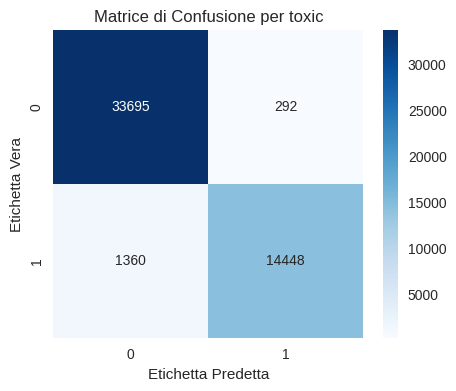


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     43096
           1       0.99      0.90      0.94      6699

    accuracy                           0.98     49795
   macro avg       0.99      0.95      0.97     49795
weighted avg       0.98      0.98      0.98     49795



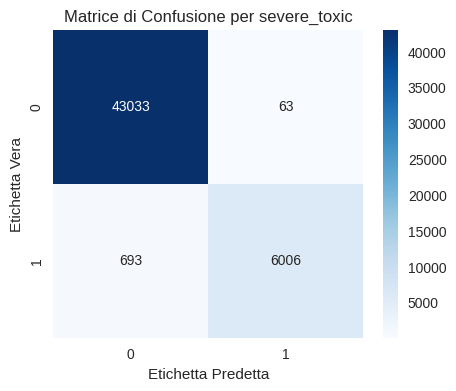


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     39513
           1       0.99      0.87      0.93     10282

    accuracy                           0.97     49795
   macro avg       0.98      0.93      0.95     49795
weighted avg       0.97      0.97      0.97     49795



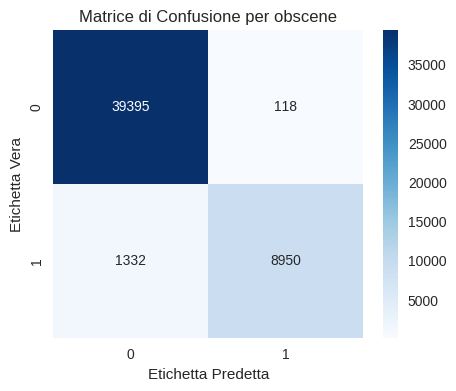


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41659
           1       1.00      0.98      0.99      8136

    accuracy                           1.00     49795
   macro avg       1.00      0.99      0.99     49795
weighted avg       1.00      1.00      1.00     49795



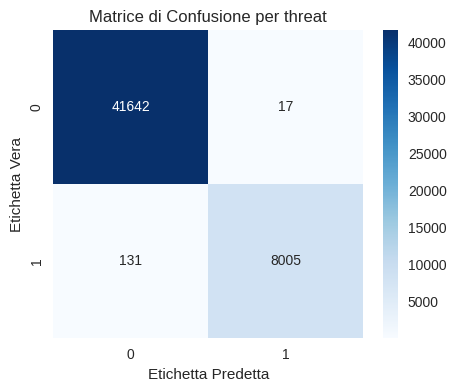


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     39087
           1       0.96      0.92      0.94     10708

    accuracy                           0.98     49795
   macro avg       0.97      0.96      0.96     49795
weighted avg       0.98      0.98      0.98     49795



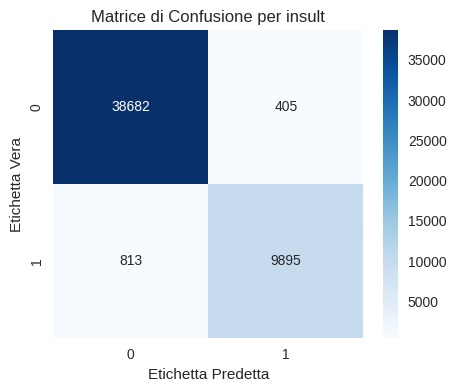


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     41662
           1       0.99      0.97      0.98      8133

    accuracy                           0.99     49795
   macro avg       0.99      0.98      0.99     49795
weighted avg       0.99      0.99      0.99     49795



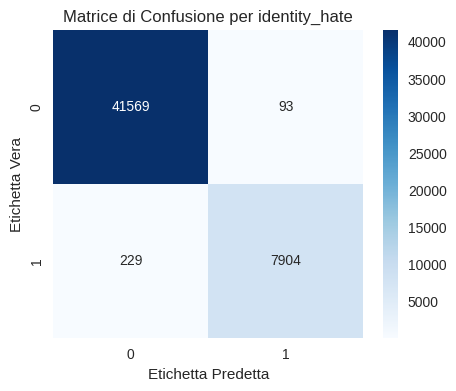

--------------------------------------------------------------------------------
Media          0.981          0.982          0.981          0.981          


In [ ]:
# Nomi delle etichette per il modello di classificazione multi-label
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Ottiene le probabilità previste dal modello sui dati di test
y_pred_proba = model.predict(X_test)

# Converte le probabilità in previsioni binarie utilizzando una soglia di 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

# Genera e stampa il rapporto di classificazione multi-label
results = generate_multi_label_classification_report(y_test, y_pred, y_pred_proba, label_names)

## Test e prediction

Questo frammento di codice implementa un sistema di analisi e visualizzazione per la classificazione di commenti potenzialmente tossici.

Utilizza il modello di deep learning addestrato in precedenza per prevedere la probabilità che un testo appartenga a diverse categorie di tossicità (come 'toxic', 'severe_toxic', 'obscene', ecc.).

La funzione `predict_toxicity` converte il testo in sequenze numeriche, applica padding, e utilizza il modello per generare sia predizioni binarie (0 o 1) che probabilità raw per ciascuna categoria.

La visualizzazione dei risultati è gestita dalla funzione `plot_grid`, che crea un grafico a barre per ciascun testo analizzato, mostrando le probabilità di tossicità e le classificazioni binarie.

Il codice applica anche una formattazione visiva dettagliata, come l'uso di colori diversi per le predizioni positive e negative, e l'aggiunta di etichette per una facile interpretazione.

Infine, il sistema processa un set di testi di esempio e stampa risultati dettagliati, fornendo sia una rappresentazione visuale che una descrizione testuale delle predizioni di tossicità per ciascun commento.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


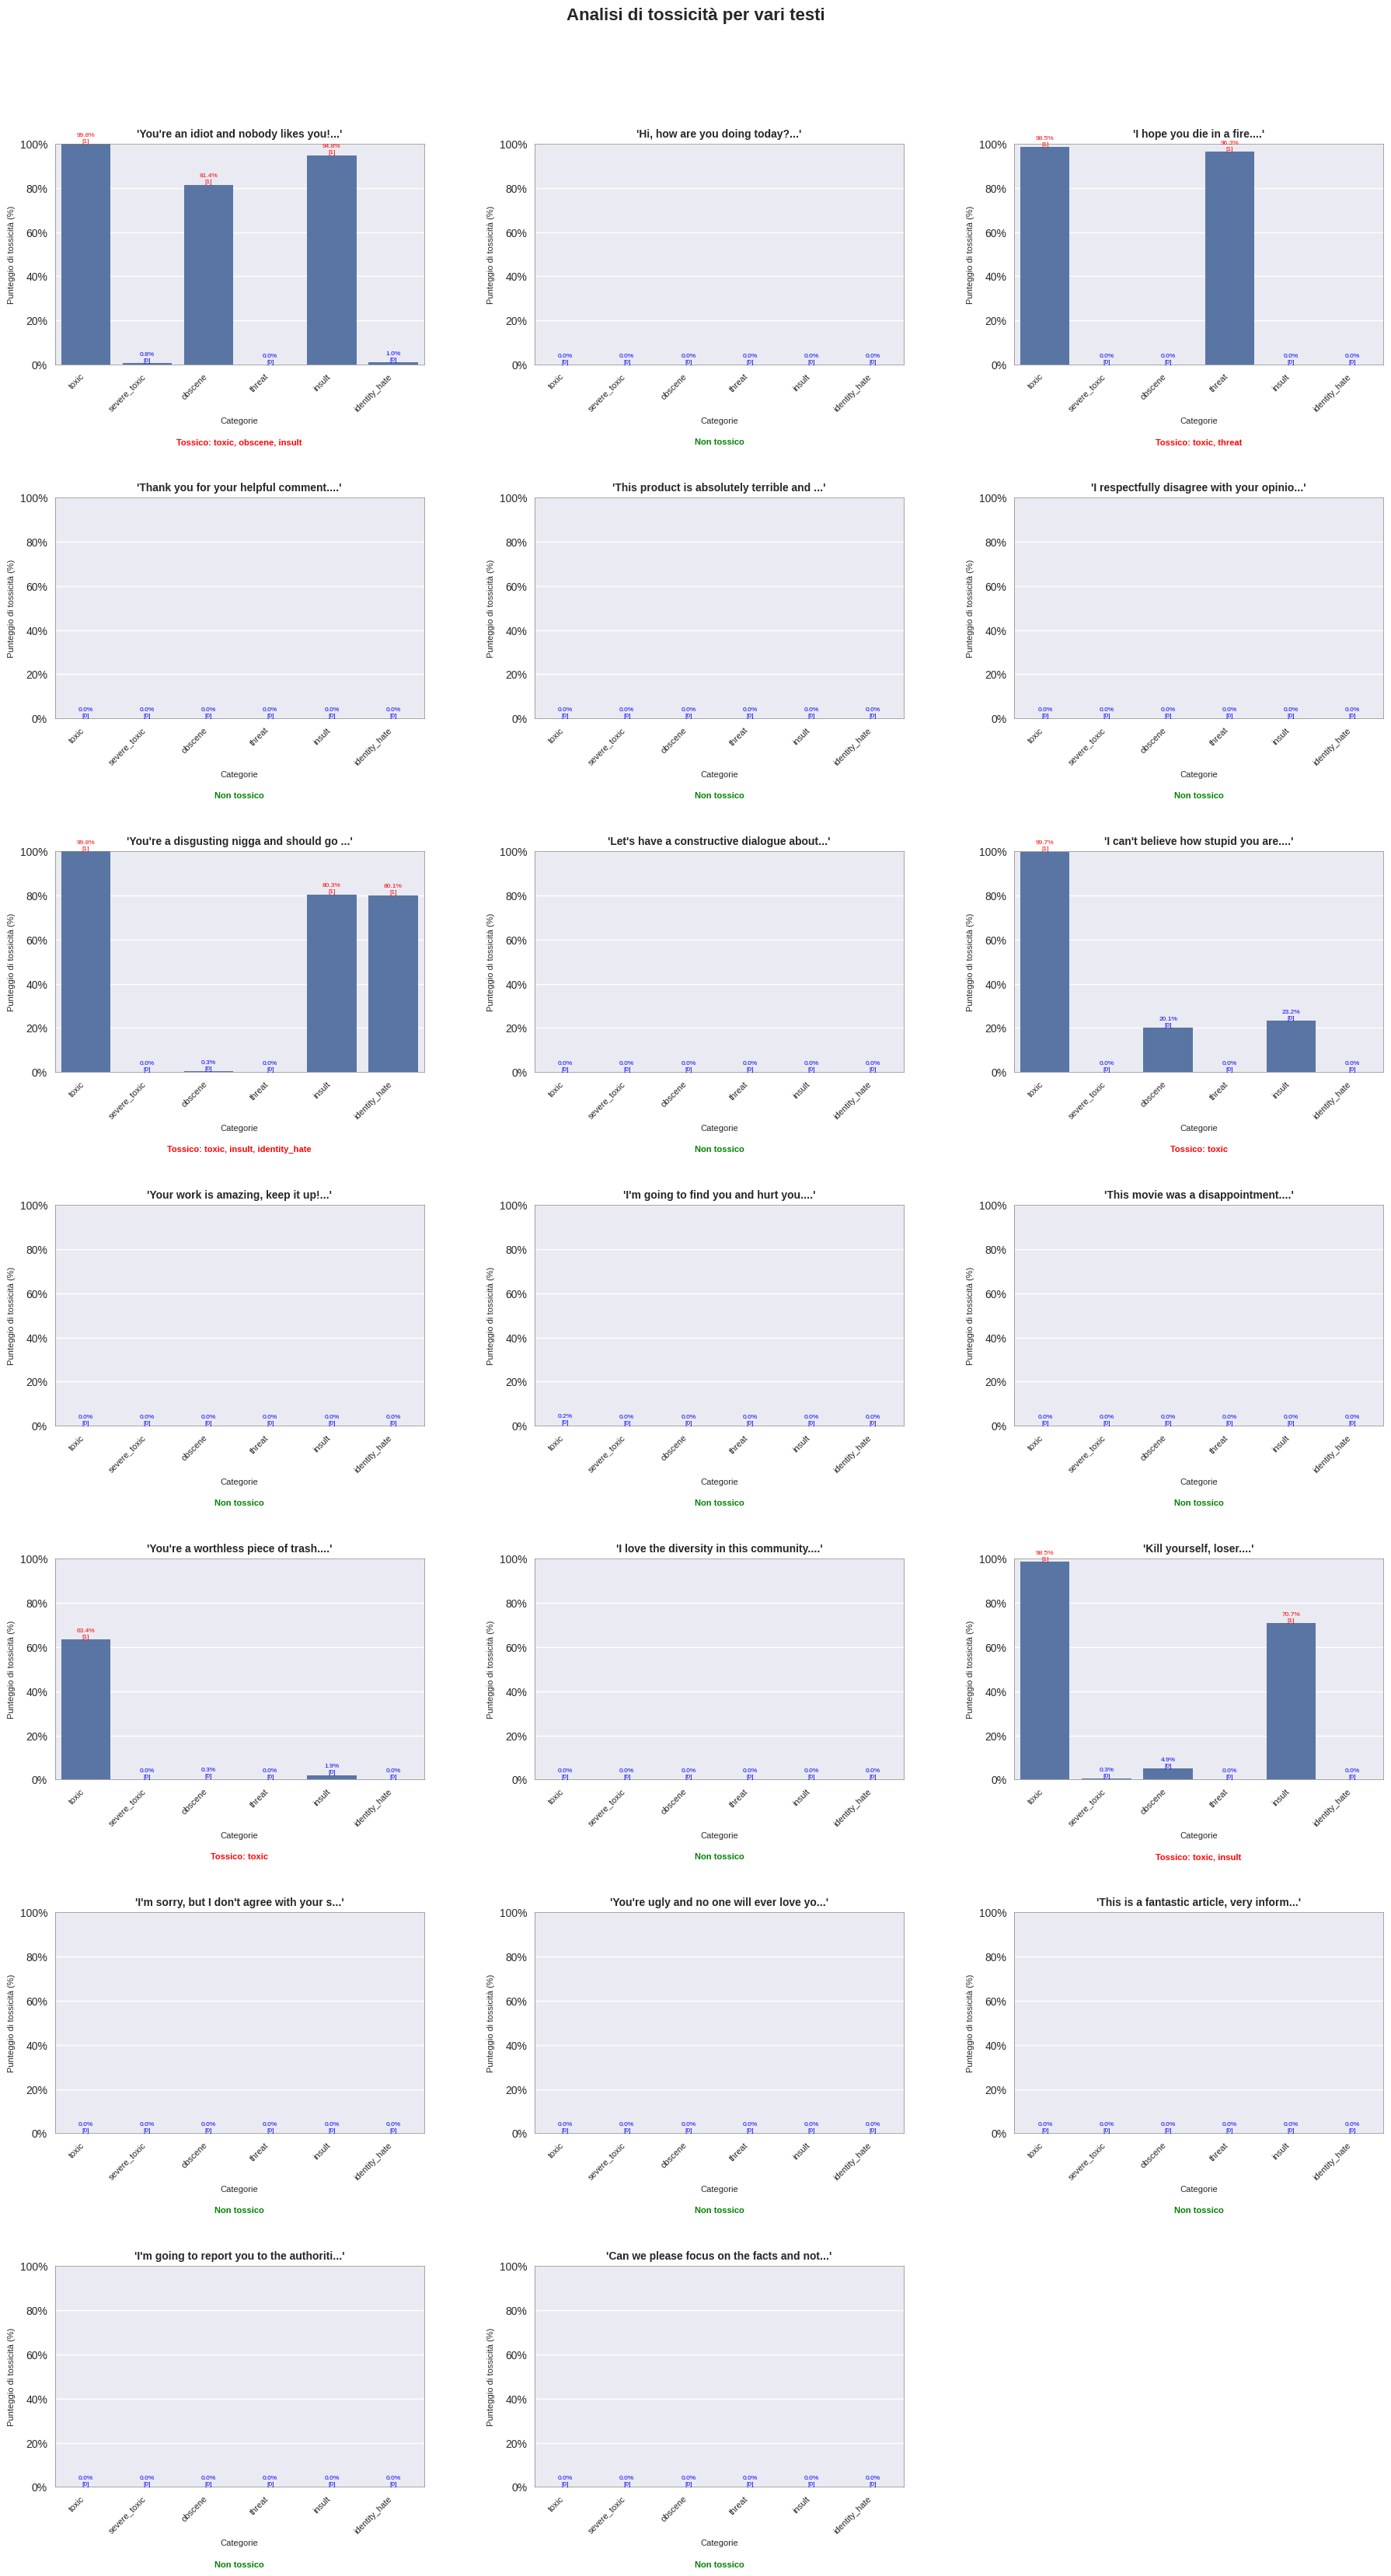


Testo: 'You're an idiot and nobody likes you!'
Predizioni binarie:
[1,0,1,0,1,0]
Predizioni raw:
toxic: 0.9984
severe_toxic: 0.0075
obscene: 0.8141
threat: 0.0000
insult: 0.9481
identity_hate: 0.0104
Classificato come: toxic, obscene, insult
--------------------------------------------------

Testo: 'Hi, how are you doing today?'
Predizioni binarie:
[0,0,0,0,0,0]
Predizioni raw:
toxic: 0.0001
severe_toxic: 0.0000
obscene: 0.0001
threat: 0.0000
insult: 0.0000
identity_hate: 0.0000
Non classificato come tossico in nessuna categoria.
--------------------------------------------------

Testo: 'I hope you die in a fire.'
Predizioni binarie:
[1,0,0,1,0,0]
Predizioni raw:
toxic: 0.9847
severe_toxic: 0.0000
obscene: 0.0000
threat: 0.9632
insult: 0.0003
identity_hate: 0.0000
Classificato come: toxic, threat
--------------------------------------------------

Testo: 'Thank you for your helpful comment.'
Predizioni binarie:
[0,0,0,0,0,0]
Predizioni raw:
toxic: 0.0000
severe_toxic: 0.0000
obscene

In [ ]:
def predict_toxicity(model, tokenizer, text, label_names, max_len, threshold=0.5):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)[0]
    binary_prediction = (prediction > threshold).astype(int)
    return {label: int(pred) for label, pred in zip(label_names, binary_prediction)}, {label: float(pred) for label, pred in zip(label_names, prediction)}

def plot_toxicity_scores(predictions, binary_predictions, title, ax):
    sns.barplot(x=list(predictions.keys()), y=list(predictions.values()), ax=ax)
    ax.set_title(title, fontsize=10, fontweight='bold', wrap=True)
    ax.set_xlabel('Categorie', fontsize=8)
    ax.set_ylabel('Punteggio di tossicità (%)', fontsize=8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.set_ylim(0, 1.0)

    # Add labels above the bars
    for i, (label, v) in enumerate(predictions.items()):
        b = binary_predictions[label]
        color = 'red' if b == 1 else 'blue'
        ax.text(i, v, f'{v:.1%}\n[{b}]', ha='center', va='bottom', fontsize=6, color=color)

def analyze_text(model, tokenizer, text, label_names, max_len, threshold=0.5):
    binary_predictions, raw_predictions = predict_toxicity(model, tokenizer, text, label_names, max_len, threshold)
    detected_labels = [label for label, pred in binary_predictions.items() if pred == 1]
    return binary_predictions, raw_predictions, detected_labels

def plot_grid(texts, results, n_cols=3):
    n_rows = (len(texts) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    fig.suptitle("Analisi di tossicità per vari testi", fontsize=16, fontweight='bold')

    for i, (text, (binary_predictions, raw_predictions, detected_labels)) in enumerate(zip(texts, results)):
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i % n_cols]
        plot_toxicity_scores(raw_predictions, binary_predictions, f"'{text[:40]}...'", ax) # Use raw_predictions and binary_predictions

        if detected_labels:
            ax.text(0.5, -0.35, f"Tossico: {', '.join(detected_labels)}",
                    ha='center', va='center', transform=ax.transAxes, fontsize=8,
                    color='red', fontweight='bold')
        else:
            ax.text(0.5, -0.35, "Non tossico",
                    ha='center', va='center', transform=ax.transAxes, fontsize=8,
                    color='green', fontweight='bold')

        # Add a border to the subplot
        for spine in ax.spines.values():
            spine.set_edgecolor('gray')
            spine.set_linewidth(0.5)

    # Hide empty axes
    for j in range(i+1, n_rows * n_cols):
        if n_rows > 1:
            axes[j // n_cols, j % n_cols].axis('off')
        else:
            axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    plt.show()

# Configurazione
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
threshold = 0.5

texts = [
    "You're an idiot and nobody likes you!",
    "Hi, how are you doing today?",
    "I hope you die in a fire.",
    "Thank you for your helpful comment.",
    "This product is absolutely terrible and the company should be ashamed.",
    "I respectfully disagree with your opinion on this matter.",
    "You're a disgusting nigga and should go back to where you came from!",
    "Let's have a constructive dialogue about our differences.",
    "I can't believe how stupid you are.",
    "Your work is amazing, keep it up!",
    "I'm going to find you and hurt you.",
    "This movie was a disappointment.",
    "You're a worthless piece of trash.",
    "I love the diversity in this community.",
    "Kill yourself, loser.",
    "I'm sorry, but I don't agree with your statement.",
    "You're ugly and no one will ever love you.",
    "This is a fantastic article, very informative!",
    "I'm going to report you to the authorities.",
    "Can we please focus on the facts and not personal attacks?"
]

# Analizza tutti i testi
results = [analyze_text(model, tokenizer, text, label_names, max_len, threshold) for text in texts]

# Visualizza i risultati in una griglia
plot_grid(texts, results)

# Stampa i risultati dettagliati
for text, (binary_predictions, raw_predictions, detected_labels) in zip(texts, results):
    print(f"\nTesto: '{text}'")
    print("Predizioni binarie:")
    print(f"[{','.join(str(v) for v in binary_predictions.values())}]")
    print("Predizioni raw:")
    for label, prob in raw_predictions.items():
        print(f"{label}: {prob:.4f}")
    if detected_labels:
        print(f"Classificato come: {', '.join(detected_labels)}")
    else:
        print("Non classificato come tossico in nessuna categoria.")
    print("-" * 50)

# Test con Naive Bayles

Questo modello è un classificatore multi-label basato su Naive Bayes che utilizza TF-IDF per trasformare i testi in rappresentazioni numeriche.

Il processo inizia con la vettorizzazione del testo tramite TF-IDF, che converte le parole in una matrice di caratteristiche numeriche.

Successivamente, il classificatore Naive Bayes viene applicato per predire le etichette multiple associate ai testi.

La funzione di valutazione calcola e visualizza le performance del modello in dettaglio, inclusi accuratezza, precisione, recall e F1-score per ciascuna etichetta, e presenta le matrici di confusione per una comprensione visiva degli errori di classificazione.

Sebbene il modello offra tempi di esecuzione notevolmente più rapidi rispetto a reti neurali più complesse, mostra una precisione inferiore, con performance di classificazione meno accurate rispetto a modelli più avanzati.

Naive Bayes Performance:

toxic:
Accuracy: 0.9275
Precision: 0.9284
Recall: 0.9275
F1-score: 0.9260

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     33987
           1       0.94      0.82      0.88     15808

    accuracy                           0.93     49795
   macro avg       0.93      0.90      0.91     49795
weighted avg       0.93      0.93      0.93     49795



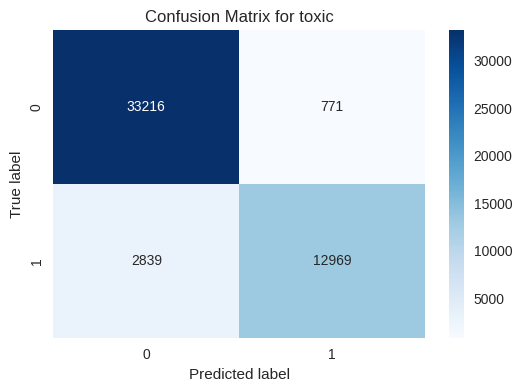


severe_toxic:
Accuracy: 0.9633
Precision: 0.9628
Recall: 0.9633
F1-score: 0.9630

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     43096
           1       0.88      0.84      0.86      6699

    accuracy                           0.96     49795
   macro avg       0.93      0.91      0.92     49795
weighted avg       0.96      0.96      0.96     49795



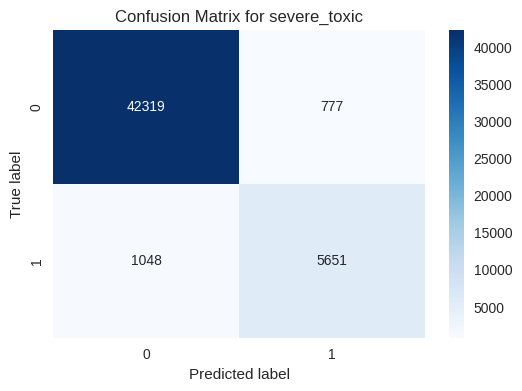


obscene:
Accuracy: 0.9350
Precision: 0.9337
Recall: 0.9350
F1-score: 0.9332

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     39513
           1       0.90      0.77      0.83     10282

    accuracy                           0.93     49795
   macro avg       0.92      0.88      0.90     49795
weighted avg       0.93      0.93      0.93     49795



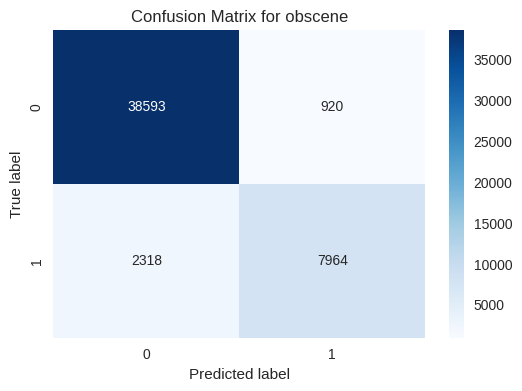


threat:
Accuracy: 0.9797
Precision: 0.9795
Recall: 0.9797
F1-score: 0.9796

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     41659
           1       0.95      0.93      0.94      8136

    accuracy                           0.98     49795
   macro avg       0.97      0.96      0.96     49795
weighted avg       0.98      0.98      0.98     49795



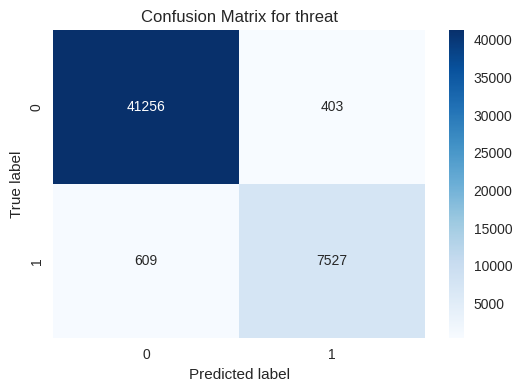


insult:
Accuracy: 0.9247
Precision: 0.9230
Recall: 0.9247
F1-score: 0.9233

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     39087
           1       0.86      0.78      0.82     10708

    accuracy                           0.92     49795
   macro avg       0.90      0.87      0.88     49795
weighted avg       0.92      0.92      0.92     49795



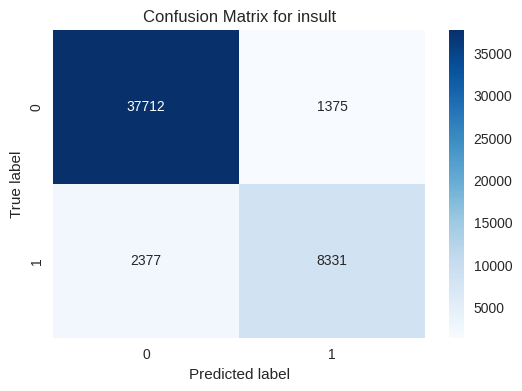


identity_hate:
Accuracy: 0.9615
Precision: 0.9608
Recall: 0.9615
F1-score: 0.9606

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     41662
           1       0.93      0.83      0.88      8133

    accuracy                           0.96     49795
   macro avg       0.95      0.91      0.93     49795
weighted avg       0.96      0.96      0.96     49795



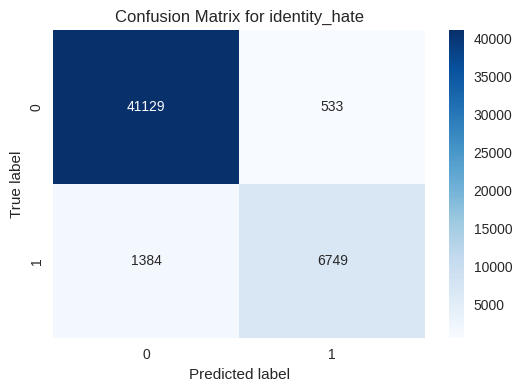


Average Performance:
Accuracy: 0.9486
Precision: 0.9480
Recall: 0.9486
F1-score: 0.9476


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class MultiLabelNaiveBayesClassifier:
    def __init__(self, max_features=10000):
        """
        Inizializza il classificatore Naive Bayes multi-label con TF-IDF.

        :param max_features: Numero massimo di caratteristiche da considerare nel TF-IDF
        """
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.classifier = MultiOutputClassifier(MultinomialNB())

    def prepare_data(self, X):
        """
        Prepara i dati per l'addestramento convertendo in stringhe e applicando il TF-IDF.

        :param X: Dati di input (testo) da trasformare
        :return: Dati trasformati con TF-IDF
        """
        X = [str(x) for x in X]
        return self.vectorizer.fit_transform(X)

    def train(self, X, y):
        """
        Allena il modello sui dati forniti.

        :param X: Dati di input (testo) per l'addestramento
        :param y: Etichette multi-label corrispondenti ai dati di input
        """
        X_tfidf = self.prepare_data(X)
        y = np.array(y).astype(int)
        self.classifier.fit(X_tfidf, y)

    def predict(self, X):
        """
        Esegue la previsione sui dati di input forniti.

        :param X: Dati di input (testo) per la previsione
        :return: Previsioni binarie per ciascuna etichetta
        """
        X = [str(x) for x in X]
        X_tfidf = self.vectorizer.transform(X)
        return self.classifier.predict(X_tfidf)

    def evaluate(self, X_test, y_test, label_names):
        """
        Valuta le prestazioni del modello sui dati di test e stampa i risultati.

        :param X_test: Dati di test per la previsione
        :param y_test: Etichette reali per i dati di test
        :param label_names: Nomi delle etichette per la visualizzazione dei risultati
        """
        y_pred = self.predict(X_test)
        y_test = np.array(y_test).astype(int)

        accuracies = []
        precisions = []
        recalls = []
        f1_scores = []

        print("Naive Bayes Performance:")
        for i, label_name in enumerate(label_names):
            accuracies.append(accuracy_score(y_test[:, i], y_pred[:, i]))
            precisions.append(precision_score(y_test[:, i], y_pred[:, i], average='weighted'))
            recalls.append(recall_score(y_test[:, i], y_pred[:, i], average='weighted'))
            f1_scores.append(f1_score(y_test[:, i], y_pred[:, i], average='weighted'))

            print(f"\n{label_name}:")
            print(f"Accuracy: {accuracies[i]:.4f}")
            print(f"Precision: {precisions[i]:.4f}")
            print(f"Recall: {recalls[i]:.4f}")
            print(f"F1-score: {f1_scores[i]:.4f}")

            print("\nClassification Report:")
            print(classification_report(y_test[:, i], y_pred[:, i]))

            # Matrice di Confusione
            cm = confusion_matrix(y_test[:, i], y_pred[:, i])
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix for {label_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

        print("\nAverage Performance:")
        print(f"Accuracy: {np.mean(accuracies):.4f}")
        print(f"Precision: {np.mean(precisions):.4f}")
        print(f"Recall: {np.mean(recalls):.4f}")
        print(f"F1-score: {np.mean(f1_scores):.4f}")

def train_and_evaluate_naive_bayes(X, y, label_names):
    """
    Allena e valuta il modello Naive Bayes multi-label.

    :param X: Dati di input (testo) per l'addestramento e la valutazione
    :param y: Etichette multi-label corrispondenti ai dati di input
    :param label_names: Nomi delle etichette per la visualizzazione dei risultati
    :return: Il modello addestrato
    """
    # Aggiungi la colonna 'label' a y per la divisione dei dati
    y['label'] = y.apply(lambda row: ''.join(row.astype(int).astype(str)), axis=1)

    # Divisione dei dati in set di addestramento e test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y['label']
    )
    y_train = y_train.drop('label', axis=1)
    y_test = y_test.drop('label', axis=1)

    # Inizializzazione e addestramento del modello
    nb_model = MultiLabelNaiveBayesClassifier()
    nb_model.train(X_train, y_train)

    # Valutazione del modello
    nb_model.evaluate(X_test, y_test, label_names)

    return nb_model

# Nomi delle etichette per il modello di classificazione multi-label
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Uso della funzione per addestrare e valutare il modello
nb_model = train_and_evaluate_naive_bayes(X_balanced, y_balanced, label_names)


# Considerazioni finali

## Prestazioni globali
Il modello CNN-RNN con Attenzione ha dimostrato una notevole precisione sia nei test formali sul dataset di test che nell'utilizzo empirico. Questa robustezza in diverse situazioni suggerisce una decente capacità di generalizzazione.

## Miglioramento delle prestazioni
L'evoluzione dell'architettura del modello ha portato a significativi miglioramenti:
1. **Velocità di elaborazione**: L'introduzione dei layer CNN ha notevolmente accelerato il processo di inferenza rispetto all'utilizzo esclusivo di RNN nelle prime iterazioni.

2. **Bilanciamento del dataset**: Il ribilanciamento del dataset si è rivelato fondamentale per il successo del training. Nei primi tentativi, le classi di commenti d'odio, essendo sottorappresentate, venivano raramente riconosciute. L'applicazione di tecniche di bilanciamento ha permesso al modello di apprendere efficacemente tutte le categorie, migliorando significativamente le prestazioni sulle classi meno frequenti.

## Sfide e limitazioni
Nonostante i risultati positivi, sono emerse alcune sfide:
1. **Scarsità di dati per alcune classi**: Alcune categorie di commenti d'odio erano rappresentate da un numero molto limitato di esempi nel dataset originale.

2. **Limiti del resampling**: Sebbene le tecniche di resampling abbiano migliorato il bilanciamento del dataset, non sono state sufficienti a garantire una generalizzazione ottimale per tutte le classi. Questo suggerisce la necessità di strategie più avanzate per affrontare lo squilibrio dei dati in scenari di classificazione multi-label.

## Comparazione con altri modelli
Come strumento di comparazione, è stato addestrato anche un modello Naive Bayes. Questo approccio si è rivelato estremamente veloce in termini di addestramento e inferenza, superando di gran lunga il modello CNN-RNN in termini di efficienza computazionale. Tuttavia, il Naive Bayes non ha raggiunto lo stesso livello di accuratezza del modello deep learning.

## Conclusioni e prospettive future
Il modello CNN-RNN con Attenzione ha dimostrato di essere un approccio promettente per il riconoscimento dei commenti d'odio, offrendo un buon equilibrio tra precisione e velocità.

Per futuri sviluppi, si potrebbero considerare:
1. L'esplorazione di tecniche più avanzate di data augmentation specifiche per il testo.

In conclusione, mentre il modello attuale rappresenta un buon punto di inizio, c'è ancora spazio per raffinamenti che potrebbero portare a prestazioni ancora migliori.